Tests for parsing the MusicXML files to training data

In [1]:
import numpy as np
import music21 as m21
from IPython.display import Image
from copy import deepcopy
from fractions import Fraction

In [2]:
allBach = m21.corpus.search('bach')


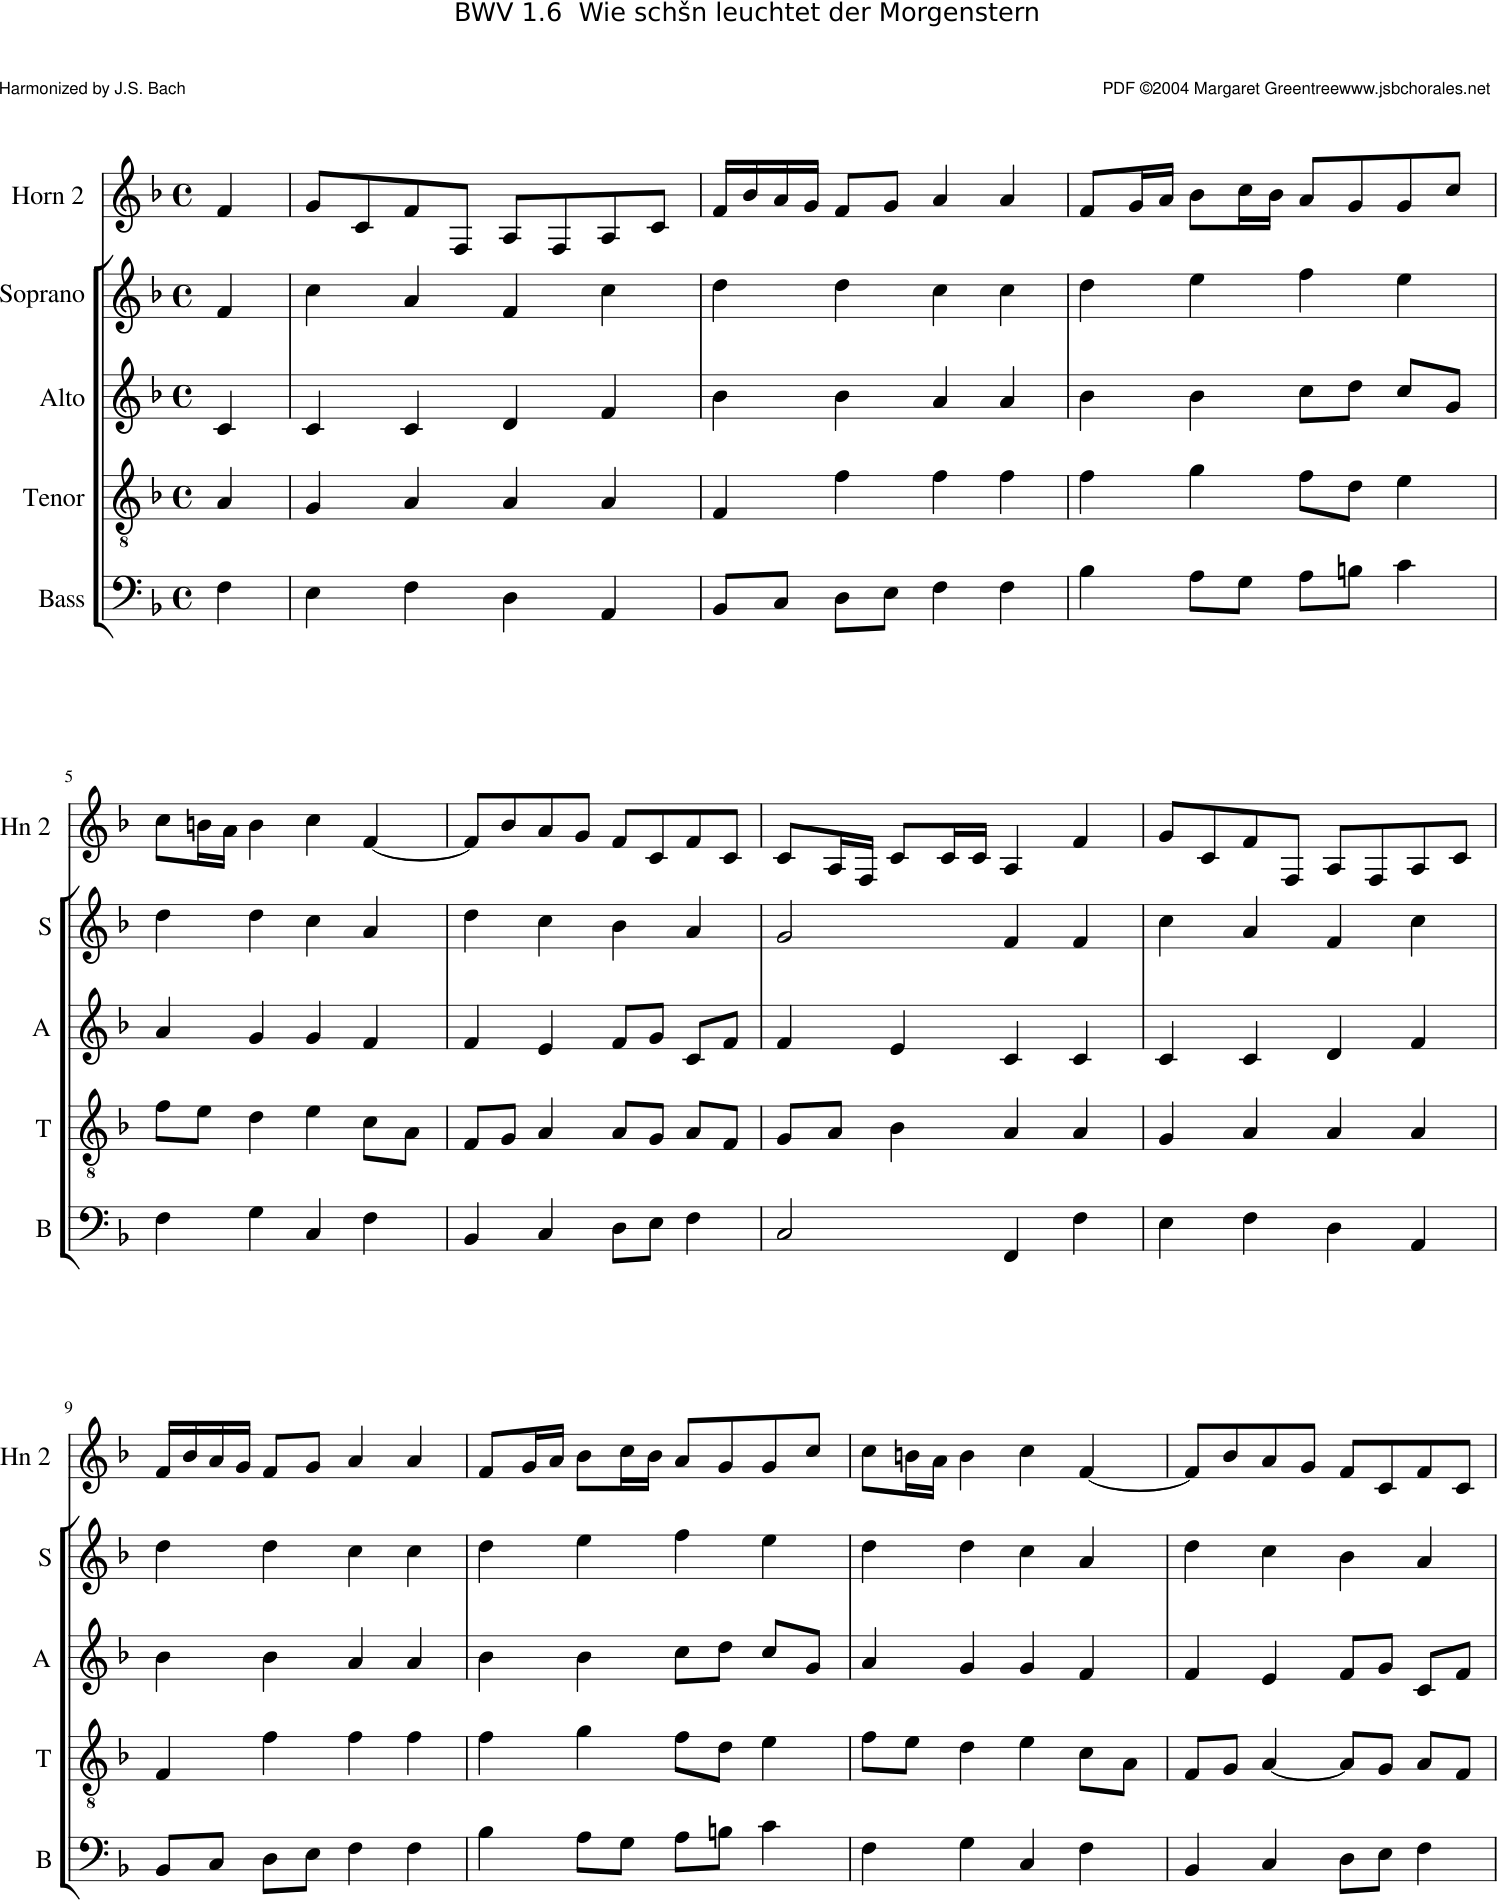

In [3]:
s1 = allBach[1].parse()
s1.show()

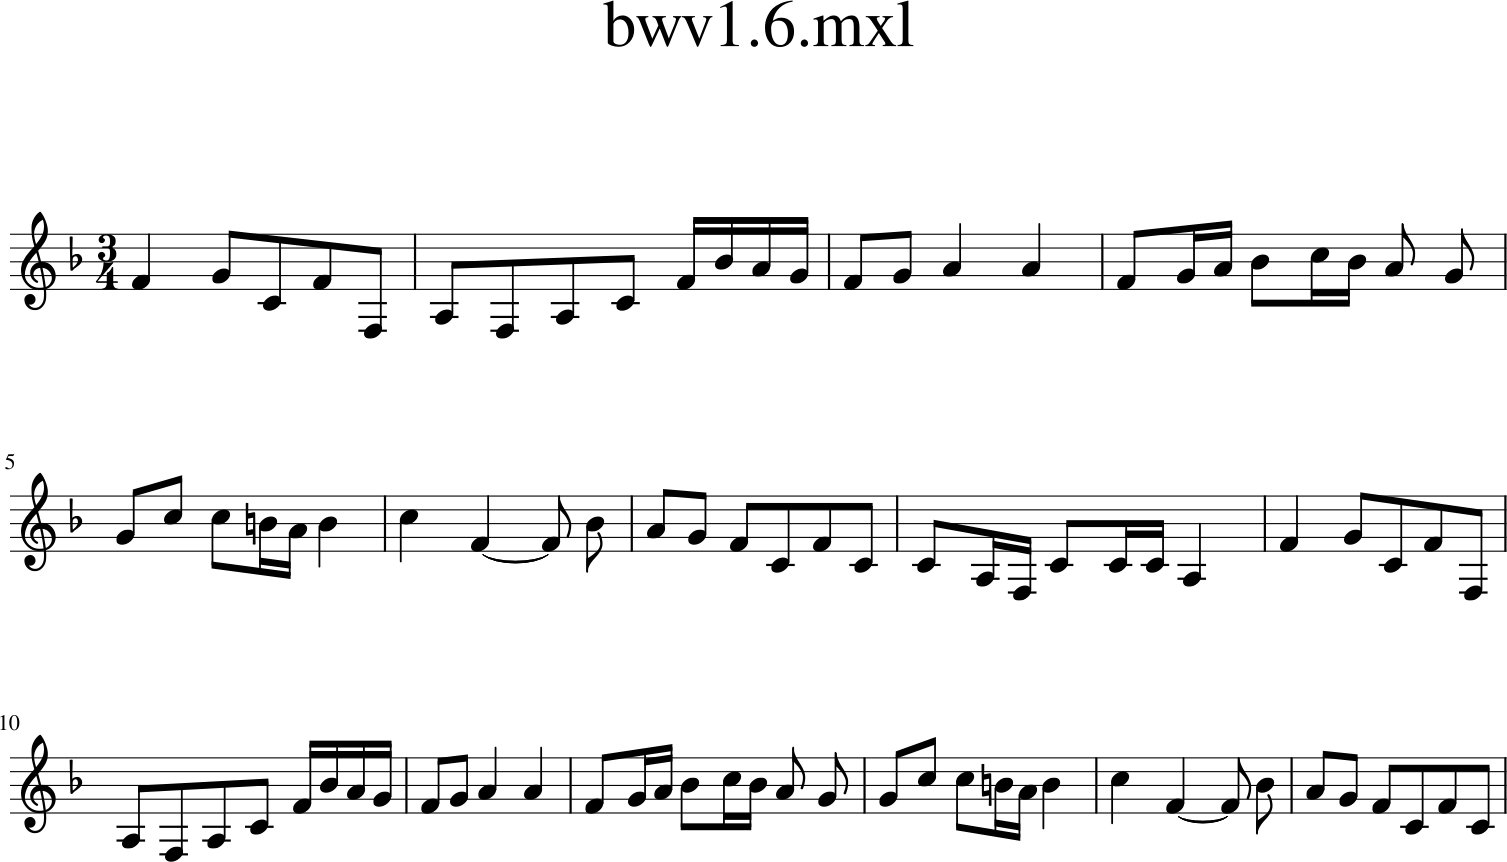

In [20]:
s1.parts[0].flat.insert(0, m21.meter.TimeSignature('3/4'))
s1.parts[0].makeMeasures().show()

In [19]:
s1.parts[0].show('text')

{0.0} <music21.instrument.Instrument P1: Horn 2: Instrument 7>
{0.0} <music21.stream.Measure 0 offset=0.0>
    {0.0} <music21.layout.PageLayout>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.key.Key of F major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Note F>
{0.0} <music21.meter.TimeSignature 3/4>
{1.0} <music21.stream.Measure 1 offset=1.0>
    {0.0} <music21.note.Note G>
    {0.5} <music21.note.Note C>
    {1.0} <music21.note.Note F>
    {1.5} <music21.note.Note F>
    {2.0} <music21.note.Note A>
    {2.5} <music21.note.Note F>
    {3.0} <music21.note.Note A>
    {3.5} <music21.note.Note C>
{5.0} <music21.stream.Measure 2 offset=5.0>
    {0.0} <music21.note.Note F>
    {0.25} <music21.note.Note B->
    {0.5} <music21.note.Note A>
    {0.75} <music21.note.Note G>
    {1.0} <music21.note.Note F>
    {1.5} <music21.note.Note G>
    {2.0} <music21.note.Note A>
    {3.0} <music21.note.Note A>
{9.0} <music21.stream.Measure 3 offset=9.0>
    {0.0} <music2

In [145]:
def clean_score(score, verbose=False):
    '''
    - Transposes to key of C
    - Sets simultaneous notes to a chord object (chordifies parts, any problems?)
    - Pads short bars with rests
    - Fixes bars that are too long (assumes notes in correct offset)
    - Strips unnecessary elements
    - etc
    '''
    
    # what is wanted in each part
    allowed = [
        m21.instrument.Instrument,
        m21.stream.Measure,
        m21.meter.TimeSignature,
        m21.clef.Clef,
        m21.key.KeySignature,
        m21.note.Note,
        m21.note.Rest,
        m21.chord.Chord
    ]
    
    if verbose: print('Cleaning...')
        
    key = score.analyze('key')
    key_diff = m21.interval.Interval(key.tonic, m21.pitch.Pitch('C'))
    if verbose: print('Found Key ({})...'.format(key))
    
    new_score = m21.stream.Score()
    
    if not isinstance(score, m21.stream.Score):
        s = m21.stream.Score()
        p = m21.stream.Part()
        p.append(score)
        s.append(p)
        score = s
        print(score)
#         score.makeNotation(inPlace=True)
    
    for part in score.parts:
        if verbose: print(part, '----------')
        
        # check if percussive clef...
        if part.recurse().getElementsByClass(m21.clef.PercussionClef):
            if verbose: print('Percussion, skipping!')
            continue
        
        new_part = m21.stream.Part()
        
        # make sure there are measures...
        if len(part.getElementsByClass(m21.stream.Measure)) == 0:
            if verbose: print('making measures...')
            part.makeMeasures(inPlace=True)
        
        # get instrument information
        ins = part.recurse().getInstrument()
        if ins:
            new_part.append(ins)
        
        # clean each measure...
        for m in part.getElementsByClass(m21.stream.Measure):
            
            new_m = m21.stream.Measure(quarterLength=m.quarterLength)
            
            # strip to core elements...
            for element in m.chordify().flat.getElementsByClass(allowed):
                if isinstance(element, m21.chord.Chord):
                    if len(element.pitches) == 1:
                        note = m21.note.Note(element.pitches[0])
                        note.duration = element.duration
                        new_m.append(note)
                        continue
                        
                new_m.append(element)
            
            if len(new_m.notesAndRests) == len(new_m.getElementsByClass(m21.note.Rest)):
                if verbose: print('rest bar found')
                new_m = m21.stream.Measure(quarterLength=m.quarterLength)
                new_m.insert(0.0, m21.note.Rest(m.barDuration))
                new_part.append(new_m)
                continue
            
            if new_m.duration.quarterLength < new_m.barDuration.quarterLength:
                if verbose: print('padding ', m.number)
                
                if m.number < 2:
                    # need to pad out the left side with a rest...
                    shift = m.paddingLeft
                    r = m21.note.Rest(quarterLength=shift)
                    new_m.insertAndShift(0, r)
                    for element in new_m.elements:
                        if element not in new_m.notesAndRests:
                            element.offset = 0.0
                else:
                    # pad on the right...
                    r = m21.note.Rest(quarterLength=m.paddingRight)
                    new_m.append(r)
                        
            
            elif m.duration.quarterLength > m.barDuration.quarterLength:
                if verbose: print('measure {} too long...'.format(m.number))
                    
                pass
 
            new_part.append(new_m)
        
        new_part.makeMeasures(inPlace=True)
        new_part.makeNotation(inPlace=True)
        
        new_score.insert(part.offset, new_part)
    
    return new_score.transpose(key_diff)

In [5]:
def parse_note_data(part, ts=None, verbose=False):
    '''
    Returns data in form (beat_stength, duration, pitch_class, octave)
    where pitch_class is -1 for rests, and has (+) operator if part of chord
    '''
    data = []
    last_octave = 4
    
    def get_octave(pitch, lo):
        if pitch.octave:
            return pitch.octave
        else:
            return lo
    
    if not ts:
        ts = part.timeSignature
        if not ts:
            ts = m21.meter.TimeSignature('4/4')
            
    if len(part.getElementsByClass(m21.stream.Measure)) == 0:
        if verbose: print('making measures...')
        part.makeMeasures(inPlace=True)
    
    for m in part.getElementsByClass("Measure"):
        if m.timeSignature:
            ts = m.timeSignature
            
        for n in m.flat.notesAndRests:
            bs = ts.getAccentWeight(n.offset, permitMeterModulus=True)
            d = n.duration.quarterLength

            if n.tie:
                if n.tie.type != "start":
                    continue

            if isinstance(n, m21.note.Note):
                last_octave = get_octave(n.pitch, last_octave)
                data.append((bs, d, str(n.pitch.pitchClass), last_octave))
                
                if verbose: print(n.offset, n, data[-1])

            elif isinstance(n, m21.note.Rest):
                data.append((bs, d, '-1', last_octave))
                
                if verbose: print(n.offset, n, data[-1])

            elif isinstance(n, m21.chord.Chord):
                ps = n.pitches
                for p in ps[:-1]:
                    last_octave =  get_octave(p, last_octave)
                    data.append((bs, d, str(p.pitchClass) + '+', last_octave))
                    if verbose: print(n.offset, n, data[-1])
                
                last_octave = get_octave(ps[-1], last_octave)
                data.append((bs, d, str(ps[-1].pitchClass), last_octave))
                if verbose: print(n.offset, n, data[-1])

            else:
                if verbose: print('Something else encountered: ', n)

            
    return data

In [6]:
parse_note_data(s1.parts[0])

[(1.0, 1.0, '5', 4),
 (1.0, 0.5, '7', 4),
 (0.125, 0.5, '0', 4),
 (0.25, 0.5, '5', 4),
 (0.125, 0.5, '5', 3),
 (0.5, 0.5, '9', 3),
 (0.125, 0.5, '5', 3),
 (0.25, 0.5, '9', 3),
 (0.125, 0.5, '0', 4),
 (1.0, 0.25, '5', 4),
 (1.0, 0.25, '10', 4),
 (0.125, 0.25, '9', 4),
 (0.125, 0.25, '7', 4),
 (0.25, 0.5, '5', 4),
 (0.125, 0.5, '7', 4),
 (0.5, 1.0, '9', 4),
 (0.25, 1.0, '9', 4),
 (1.0, 0.5, '5', 4),
 (0.125, 0.25, '7', 4),
 (0.125, 0.25, '9', 4),
 (0.25, 0.5, '10', 4),
 (0.125, 0.25, '0', 5),
 (0.125, 0.25, '10', 4),
 (0.5, 0.5, '9', 4),
 (0.125, 0.5, '7', 4),
 (0.25, 0.5, '7', 4),
 (0.125, 0.5, '0', 5),
 (1.0, 0.5, '0', 5),
 (0.125, 0.25, '11', 4),
 (0.125, 0.25, '9', 4),
 (0.25, 1.0, '11', 4),
 (0.5, 1.0, '0', 5),
 (0.25, 1.0, '5', 4),
 (0.125, 0.5, '10', 4),
 (0.25, 0.5, '9', 4),
 (0.125, 0.5, '7', 4),
 (0.5, 0.5, '5', 4),
 (0.125, 0.5, '0', 4),
 (0.25, 0.5, '5', 4),
 (0.125, 0.5, '0', 4),
 (1.0, 0.5, '0', 4),
 (0.125, 0.25, '9', 3),
 (0.125, 0.25, '5', 3),
 (0.25, 0.5, '0', 4),
 (0.1

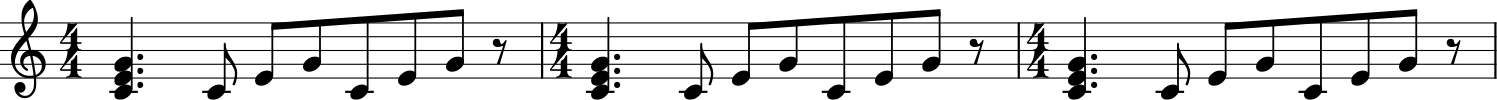

In [7]:
s = m21.stream.Score()
p1 = m21.stream.Part()
m1 = m21.stream.Measure()
m1.insert(0.0, m21.meter.TimeSignature('4/4'))
m1.insert(0.0, m21.chord.Chord(['C4', 'E4', 'G4'], quarterLength=1.5))
m1.insert(1.5, m21.note.Note('C4', quarterLength=0.5))
m1.insert(2.0, m21.note.Note('E4', quarterLength=0.5))
m1.insert(2.5, m21.note.Note('G4', quarterLength=0.5))
m1.insert(3.0, m21.note.Note('C4', quarterLength=0.5))
m1.insert(3.0, m21.note.Note('E4', quarterLength=0.5))
m1.insert(3.0, m21.note.Note('G4', quarterLength=0.5))
m1.insert(3.5, m21.note.Rest(quarterLength=0.5))
p1.repeatInsert(m1, [0, 4, 8])
s.insert(0, p1)
s.show()
# s.show('text')
# s.show('midi')

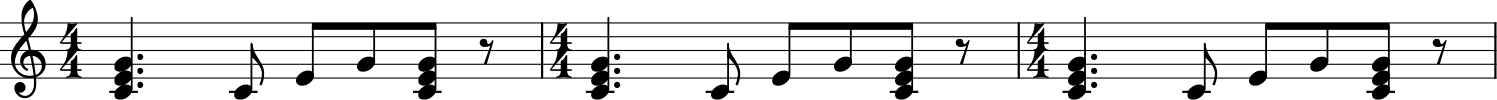

In [8]:
clean_score(s).show()

In [111]:
parse_note_data(clean_score(s).parts[0])

0.0 <music21.chord.Chord C4 E4 G4> (1.0, '0+', 4)
0.0 <music21.chord.Chord C4 E4 G4> (1.0, '4+', 4)
0.0 <music21.chord.Chord C4 E4 G4> [1.0, '7', 4]
1.5 <music21.chord.Chord C4> [0.125, '0', 4]
2.0 <music21.chord.Chord E4> [0.5, '4', 4]
2.5 <music21.chord.Chord G4> [0.125, '7', 4]
3.0 <music21.chord.Chord C4 E4 G4> (0.25, '0+', 4)
3.0 <music21.chord.Chord C4 E4 G4> (0.25, '4+', 4)
3.0 <music21.chord.Chord C4 E4 G4> [0.25, '7', 4]
3.5 <music21.note.Rest rest> (0.125, '-1', 4)
4.0 <music21.chord.Chord C4 E4 G4> (1.0, '0+', 4)
4.0 <music21.chord.Chord C4 E4 G4> (1.0, '4+', 4)
4.0 <music21.chord.Chord C4 E4 G4> [1.0, '7', 4]
5.5 <music21.chord.Chord C4> [0.125, '0', 4]
6.0 <music21.chord.Chord E4> [0.5, '4', 4]
6.5 <music21.chord.Chord G4> [0.125, '7', 4]
7.0 <music21.chord.Chord C4 E4 G4> (0.25, '0+', 4)
7.0 <music21.chord.Chord C4 E4 G4> (0.25, '4+', 4)
7.0 <music21.chord.Chord C4 E4 G4> [0.25, '7', 4]
7.5 <music21.note.Rest rest> (0.125, '-1', 4)
8.0 <music21.chord.Chord C4 E4 G4> (1.0,

[(1.0, '0+', 4),
 (1.0, '4+', 4),
 [1.0, '7', 4],
 [0.125, '0', 4],
 [0.5, '4', 4],
 [0.125, '7', 4],
 (0.25, '0+', 4),
 (0.25, '4+', 4),
 [0.25, '7', 4],
 (0.125, '-1', 4),
 (1.0, '0+', 4),
 (1.0, '4+', 4),
 [1.0, '7', 4],
 [0.125, '0', 4],
 [0.5, '4', 4],
 [0.125, '7', 4],
 (0.25, '0+', 4),
 (0.25, '4+', 4),
 [0.25, '7', 4],
 (0.125, '-1', 4),
 (1.0, '0+', 4),
 (1.0, '4+', 4),
 [1.0, '7', 4],
 [0.125, '0', 4],
 [0.5, '4', 4],
 [0.125, '7', 4],
 (0.25, '0+', 4),
 (0.25, '4+', 4),
 [0.25, '7', 4],
 (0.125, '-1', 4)]

In [103]:
cs1 = clean_score(s1)
cs1.parts.show('text')

{0.0} <music21.stream.Part Horn 2>
    {0.0} <music21.instrument.Instrument P1: Horn 2: Instrument 7>
    {0.0} <music21.stream.Measure 0 offset=0.0>
        {0.0} <music21.layout.PageLayout>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.key.Key of C major>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.note.Rest rest>
        {3.0} <music21.chord.Chord C4>
    {4.0} <music21.stream.Measure 1 offset=4.0>
        {0.0} <music21.chord.Chord D4>
        {0.5} <music21.chord.Chord G3>
        {1.0} <music21.chord.Chord C4>
        {1.5} <music21.chord.Chord C3>
        {2.0} <music21.chord.Chord E3>
        {2.5} <music21.chord.Chord C3>
        {3.0} <music21.chord.Chord E3>
        {3.5} <music21.chord.Chord G3>
    {8.0} <music21.stream.Measure 2 offset=8.0>
        {0.0} <music21.chord.Chord C4>
        {0.25} <music21.chord.Chord F4>
        {0.5} <music21.chord.Chord E4>
        {0.75} <music21.chord.Chord D4>
        {1.0} <music21.chord.Chor

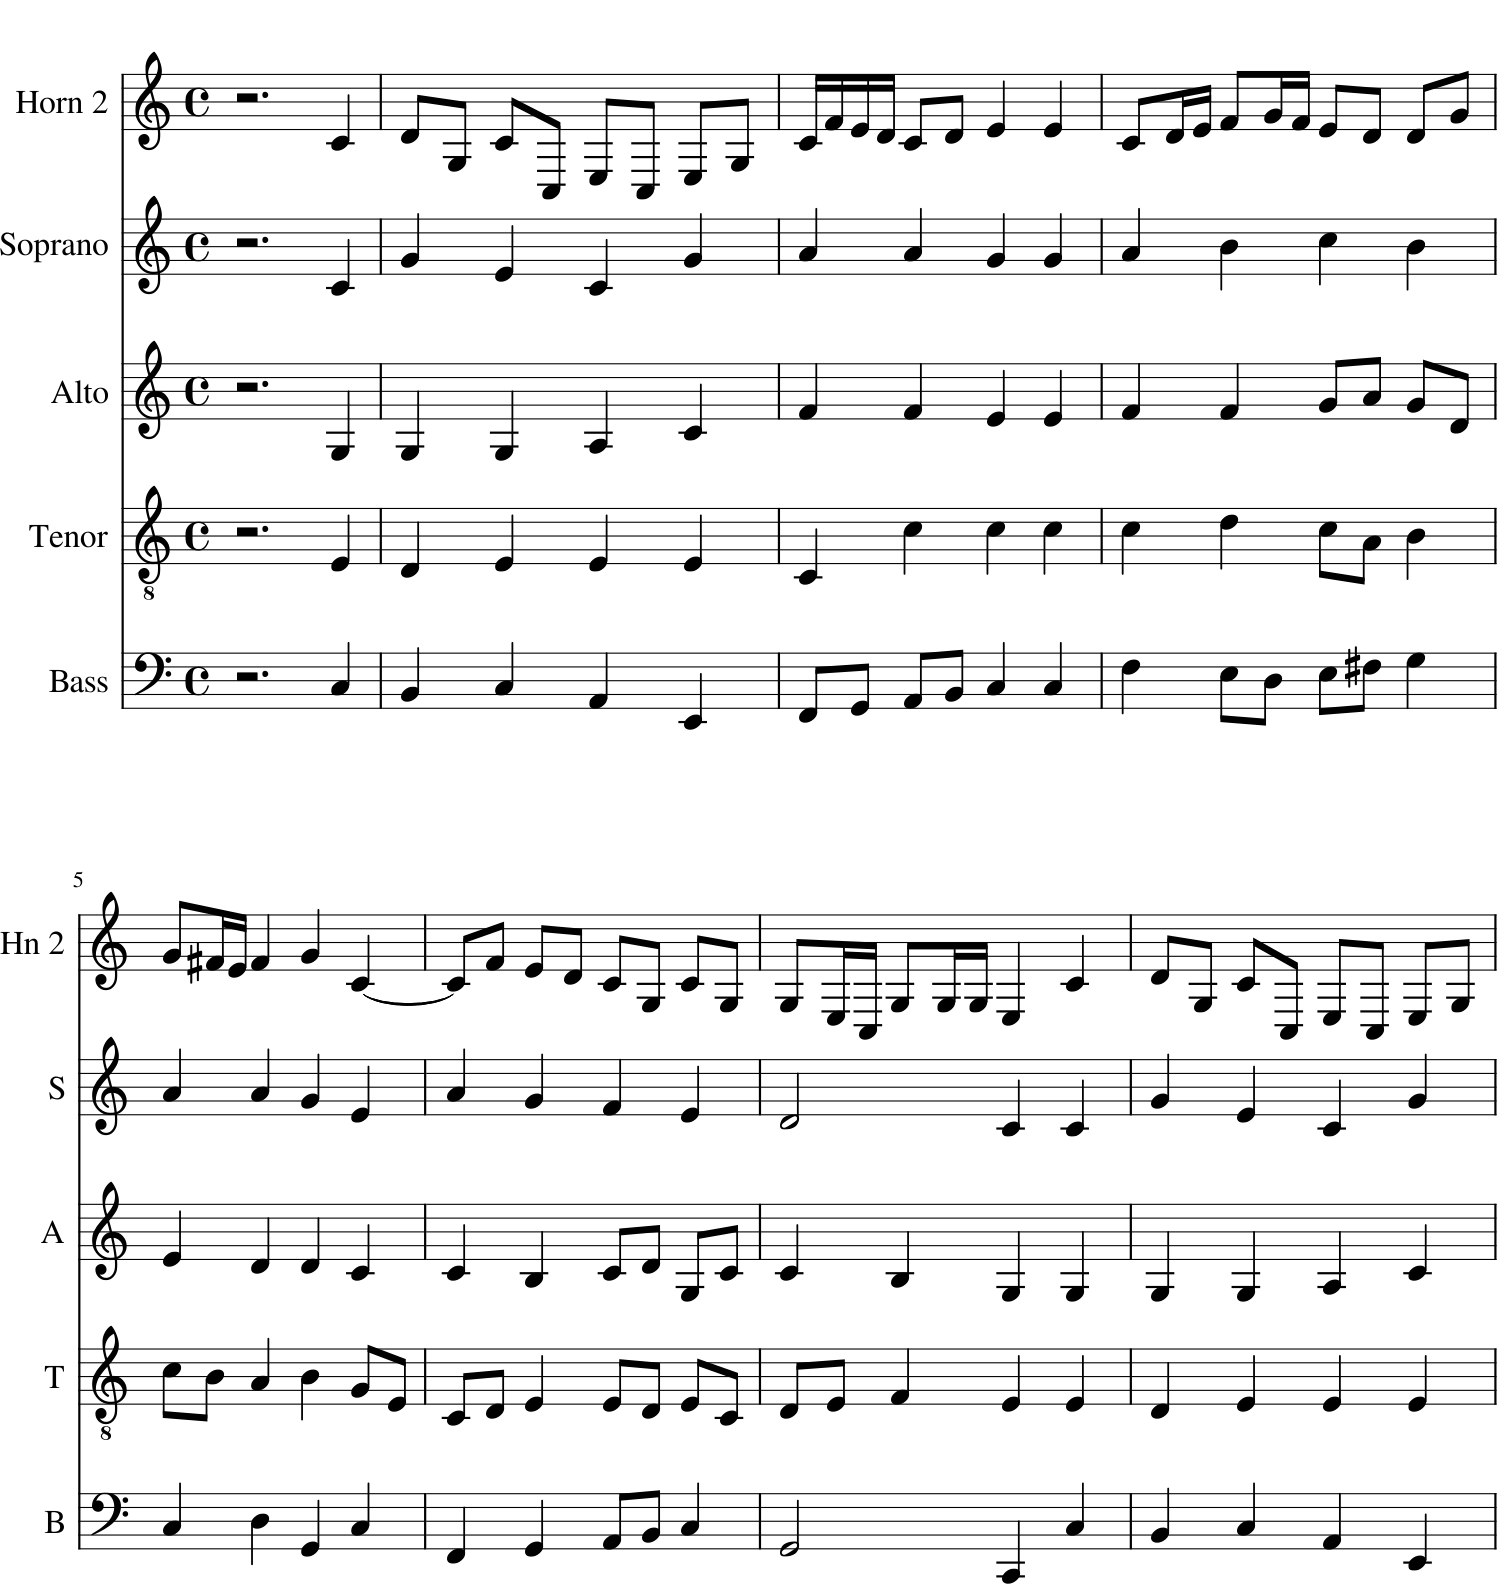

In [105]:
cs1.show()

In [6]:
s2 = clean_score(deepcopy(s1))

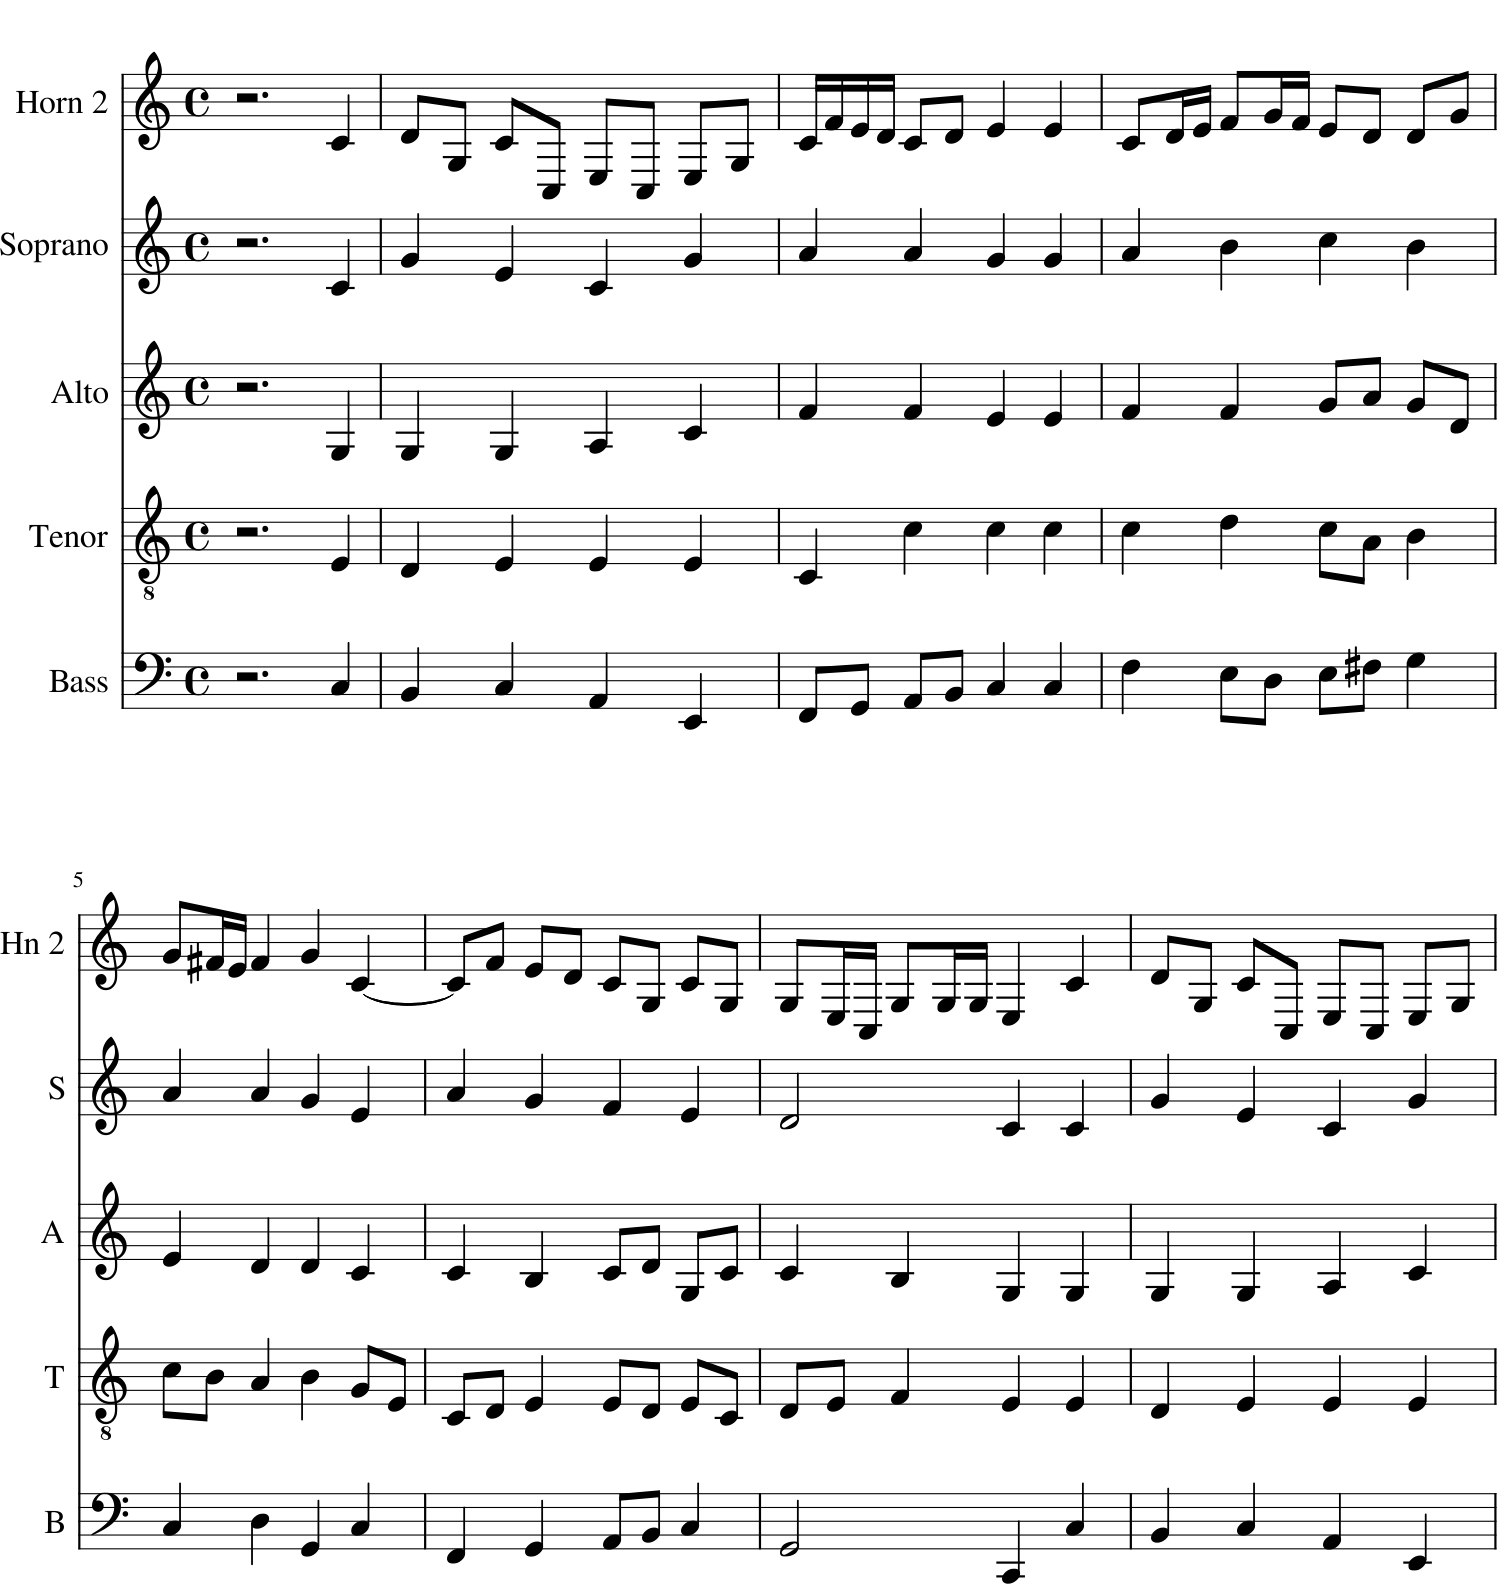

In [7]:
s2.show()

In [6]:
def rhythm_word(part, force_ts=None, verbose=False):
    '''
    Splits the score into single beat length 'words' that contain offset and tie information from that beat.
    - Includes START token with Time Signature information
    - Gets the length of the beat from the Time Signature
    - Robust against odd time signatures and tied notes
    '''
    
    data = []
    
    if force_ts:
        ts = force_ts
    else:
        ts = m21.meter.TimeSignature('4/4')
    
    beat_length = Fraction(ts.beatDuration.quarterLength)
    
    if len(part.getElementsByClass(m21.stream.Measure)) == 0:
        if verbose: print('making measures...')
        part.makeMeasures(inPlace=True)
    
    for m in part.getElementsByClass("Measure"):
        if m.timeSignature and not force_ts:
            ts = m.timeSignature
            beat_length = Fraction(ts.beatDuration.quarterLength)
            if verbose: print('New ts: ', ts, beat_length)
            
        off = m.offset
            
        for i in np.arange(m.duration.quarterLength, step=beat_length):
            w = m.flat.getElementsByOffset(i, i+beat_length, includeEndBoundary=False)
            word = []
            for x in w.flat.notesAndRests:
                if x.tie:
                    if x.tie.type != 'start':
                        continue

                word.append(x.offset - i)

            data.append(word) 
            if verbose: print(word)
    
    return data

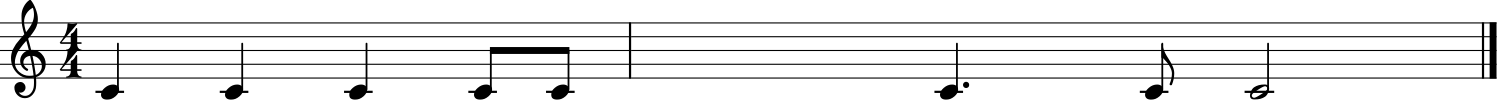

In [134]:
test_score = m21.stream.Score()
p1 = m21.stream.Part()
p1.append(m21.note.Note('c', quarterLength=1.0))
p1.append(m21.note.Note('c', quarterLength=1.0))
p1.append(m21.note.Note('c', quarterLength=1.0))
p1.append(m21.note.Note('c', quarterLength=0.5))
p1.append(m21.note.Note('c', quarterLength=0.5))
p1.append(m21.note.Note('c', quarterLength=1.5))
p1.append(m21.note.Note('c', quarterLength=0.5))
p1.append(m21.note.Note('c', quarterLength=2.0))

test_score.insert(0, p1)
test_score.makeMeasures(inPlace=True)
test_score.makeNotation(inPlace=True)
test_score.show()

In [53]:
for m in test_score.getElementsByClass("Measure"):
    print(m, m.barDuration, m.timeSignature)

<music21.stream.Measure 1 offset=0.0> <music21.duration.Duration 4.0> <music21.meter.TimeSignature 4/4>
<music21.stream.Measure 2 offset=4.0> <music21.duration.Duration 4.0> None


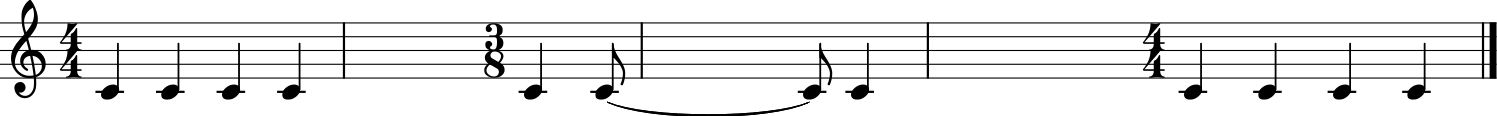

In [8]:
test_score2 = m21.stream.Score()
p2 = m21.stream.Part()
m1 = m21.stream.Measure()
m1.append(m21.meter.TimeSignature('4/4'))
m1.repeatAppend(m21.note.Note('c', quarterLength=1.0), 4)
m2 = m21.stream.Measure()
m2.append(m21.meter.TimeSignature('3/8'))
m2.repeatAppend(m21.note.Note('c', quarterLength=1.0), 3)
p2.append(m1)
p2.append(m2)
p2.append(deepcopy(m1))

test_score2.insert(0, p2)
test_score2.makeMeasures(inPlace=True)
test_score2.makeNotation(inPlace=True)
test_score2.show()

In [18]:
rhythm_word(test_score2)

[[0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [],
 [0.0],
 [],
 [0.0],
 [],
 [0.0],
 [0.0],
 [0.0],
 [0.0]]

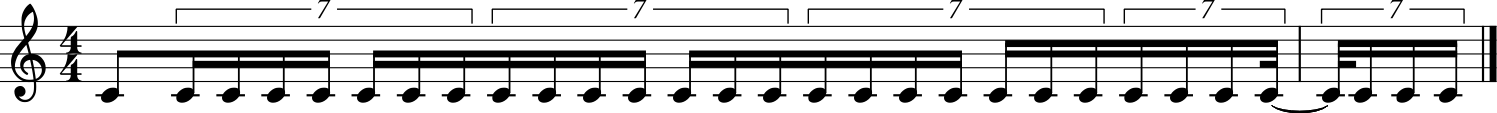

In [43]:
t = m21.duration.Tuplet(7, 4)
t.setDurationType('16th')
d = m21.duration.Duration('16th')
d.appendTuplet(t)
n = m21.note.Note('C4')
n.duration = d
s = m21.stream.Stream()
s.append(m21.meter.TimeSignature('4/4'))
s.append(m21.note.Note('C4', quarterLength=0.5))
s.repeatAppend(n, 28)
s.show()

Cleaning...
Found Key (F major)...
<music21.stream.Score 0x7fd99b36d160>
<music21.stream.Part 0x7fd99b36d080> ----------
making measures...
measure 1 too long...
padding  2


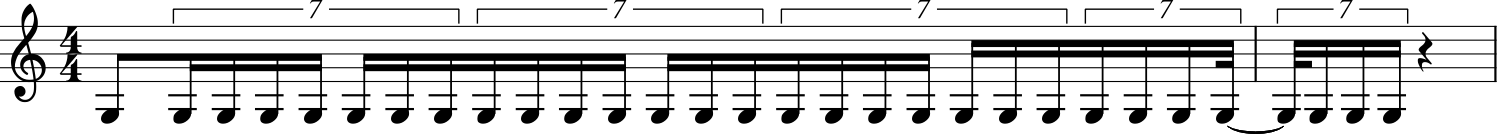

In [44]:
cs = clean_score(s, verbose=True)
cs.show()

In [46]:
for w in rhythm_word(cs, verbose=True):
    print(w)

making measures...
New ts:  <music21.meter.TimeSignature 4/4> 1
[0.0, 0.5, Fraction(9, 14), Fraction(11, 14), Fraction(13, 14)]
[Fraction(1, 14), Fraction(3, 14), Fraction(5, 14), 0.5, Fraction(9, 14), Fraction(11, 14), Fraction(13, 14)]
[Fraction(1, 14), Fraction(3, 14), Fraction(5, 14), 0.5, Fraction(9, 14), Fraction(11, 14), Fraction(13, 14)]
[Fraction(1, 14), Fraction(3, 14), Fraction(5, 14), 0.5, Fraction(9, 14), Fraction(11, 14), Fraction(13, 14)]
[Fraction(1, 14), Fraction(3, 14), Fraction(5, 14), 0.5]
[]
[0.0, 0.5, Fraction(9, 14), Fraction(11, 14), Fraction(13, 14)]
[Fraction(1, 14), Fraction(3, 14), Fraction(5, 14), 0.5, Fraction(9, 14), Fraction(11, 14), Fraction(13, 14)]
[Fraction(1, 14), Fraction(3, 14), Fraction(5, 14), 0.5, Fraction(9, 14), Fraction(11, 14), Fraction(13, 14)]
[Fraction(1, 14), Fraction(3, 14), Fraction(5, 14), 0.5, Fraction(9, 14), Fraction(11, 14), Fraction(13, 14)]
[Fraction(1, 14), Fraction(3, 14), Fraction(5, 14), 0.5]
[]


In [47]:
s2.parts[0].show()

NameError: name 's2' is not defined

In [15]:
words = rhythm_word(s2.parts[0])
print(words)
print(len(words))
print(s2.parts[0].duration)

[[0.0], [], [], [0.0], [0.0, 0.5], [0.0, 0.5], [0.0, 0.5], [0.0, 0.5], [0.0, 0.25, 0.5, 0.75], [0.0, 0.5], [0.0], [0.0], [0.0, 0.5, 0.75], [0.0, 0.5, 0.75], [0.0, 0.5], [0.0, 0.5], [0.0, 0.5, 0.75], [0.0], [0.0], [0.0], [0.5], [0.0, 0.5], [0.0, 0.5], [0.0, 0.5], [0.0, 0.5, 0.75], [0.0, 0.5, 0.75], [0.0], [0.0], [0.0, 0.5], [0.0, 0.5], [0.0, 0.5], [0.0, 0.5], [0.0, 0.25, 0.5, 0.75], [0.0, 0.5], [0.0], [0.0], [0.0, 0.5, 0.75], [0.0, 0.5, 0.75], [0.0, 0.5], [0.0, 0.5], [0.0, 0.5, 0.75], [0.0], [0.0], [0.0], [0.5], [0.0, 0.5], [0.0, 0.5], [0.0, 0.5], [0.0, 0.5, 0.75], [0.0, 0.5, 0.75], [0.0], [0.0], [0.0, 0.5, 0.75], [0.0, 0.25, 0.5, 0.75], [0.0], [], [0.0, 0.25, 0.5, 0.75], [0.0], [0.0], [], [0.0, 0.5], [0.0, 0.5], [0.0, 0.5, 0.75], [0.0, 0.5, 0.75], [0.0, 0.5], [0.0, 0.5], [0.0], [0.5], [0.0, 0.5, 0.75], [0.0], [0.5], [0.0, 0.5, 0.75], [0.0], [], [0.0, 0.25, 0.5, 0.75], [0.0], [0.5], [0.5], [0.5], [0.5], [0.5], [0.0, 0.5, 0.75], [0.0]]
83
<music21.duration.Duration 83.0>


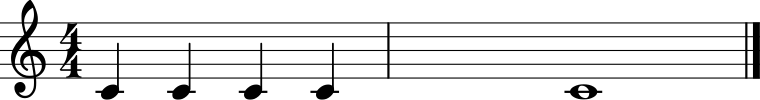

In [48]:
s3 = m21.stream.Score()
s3.repeatAppend(m21.note.Note('C4', quarterLength=1.0), 4)
s3.append(m21.note.Note('C4', quarterLength=4.0))
s3.show()
# s3.show('midi')

In [49]:
rhythm_word(s3)

[[0.0], [0.0], [0.0], [0.0], [0.0], [], [], []]

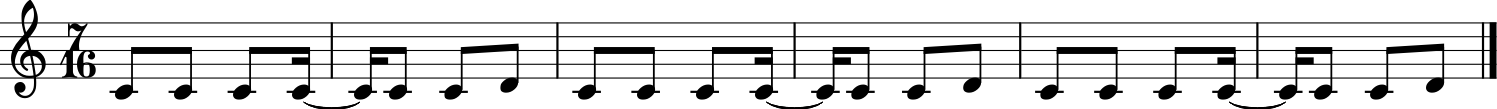

In [55]:
s4 = m21.stream.Stream()
ts = m21.meter.TimeSignature('7/16')
s4.insert(0.0, ts)
m4 = m21.stream.Measure()
n = m21.note.Note('C4', quarterLength=0.5)
m4.repeatAppend(n, 6)
m4.append(m21.note.Note('D4', quarterLength=0.5))
s4.repeatAppend(m4, 3)
s4.makeMeasures(inPlace=True)
s4.makeNotation(inPlace=True)
s4.show()

In [56]:
rhythm_word(s4)

[[0.0],
 [],
 [0.0],
 [],
 [0.0],
 [],
 [0.0],
 [],
 [0.0],
 [],
 [0.0],
 [],
 [0.0],
 [],
 [0.0],
 [],
 [0.0],
 [],
 [0.0],
 [],
 [0.0],
 [],
 [0.0],
 [],
 [0.0],
 [],
 [0.0],
 [],
 [0.0],
 [],
 [0.0],
 [],
 [0.0],
 [],
 [0.0],
 [],
 [0.0],
 [],
 [0.0],
 [],
 [0.0],
 []]

In [57]:
s4.show('text')

{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.meter.TimeSignature 7/16>
    {0.0} <music21.note.Note C>
    {0.5} <music21.note.Note C>
    {1.0} <music21.note.Note C>
    {1.5} <music21.note.Note C>
{1.75} <music21.stream.Measure 2 offset=1.75>
    {0.0} <music21.note.Note C>
    {0.25} <music21.note.Note C>
    {0.75} <music21.note.Note C>
    {1.25} <music21.note.Note D>
{3.5} <music21.stream.Measure 3 offset=3.5>
    {0.0} <music21.note.Note C>
    {0.5} <music21.note.Note C>
    {1.0} <music21.note.Note C>
    {1.5} <music21.note.Note C>
{5.25} <music21.stream.Measure 4 offset=5.25>
    {0.0} <music21.note.Note C>
    {0.25} <music21.note.Note C>
    {0.75} <music21.note.Note C>
    {1.25} <music21.note.Note D>
{7.0} <music21.stream.Measure 5 offset=7.0>
    {0.0} <music21.note.Note C>
    {0.5} <music21.note.Note C>
    {1.0} <music21.note.Note C>
    {1.5} <music21.note.Note C>
{8.75} <music21.stream.Measure 6 offset=8.75>
   

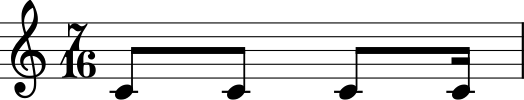

<music21.duration.Duration 1.75>
1 : 7/16
[[0.0], [], [0.0], [], [0.0], [], [0.0]]
[(1.0, 0.5, '0', 4), (0.5, 0.5, '0', 4), (0.5, 0.5, '0', 4), (0.5, 0.25, '0', 4)]


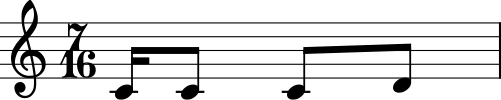

<music21.duration.Duration 1.75>
2 : 7/16
[[], [0.0], [], [0.0], [], [0.0], []]
[(1.0, 0.5, '0', 4), (0.125, 0.5, '0', 4), (0.25, 0.5, '2', 4)]


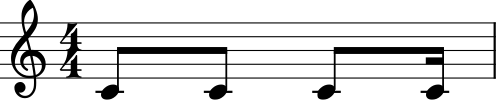

<music21.duration.Duration 1.75>
3 : 7/16
[[0.0], [], [0.0], [], [0.0], [], [0.0]]
[(1.0, 0.5, '0', 4), (0.125, 0.5, '0', 4), (0.25, 0.5, '0', 4), (0.125, 0.25, '0', 4)]


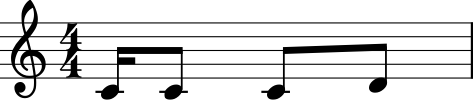

<music21.duration.Duration 1.75>
4 : 7/16
[[], [0.0], [], [0.0], [], [0.0], []]
[(1.0, 0.5, '0', 4), (0.125, 0.5, '0', 4), (0.25, 0.5, '2', 4)]


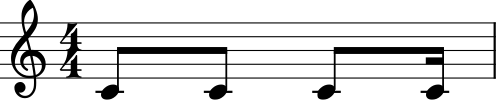

<music21.duration.Duration 1.75>
5 : 7/16
[[0.0], [], [0.0], [], [0.0], [], [0.0]]
[(1.0, 0.5, '0', 4), (0.125, 0.5, '0', 4), (0.25, 0.5, '0', 4), (0.125, 0.25, '0', 4)]


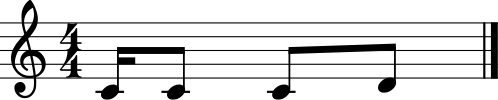

<music21.duration.Duration 1.75>
6 : 7/16
[[], [0.0], [], [0.0], [], [0.0], []]
[(1.0, 0.5, '0', 4), (0.125, 0.5, '0', 4), (0.25, 0.5, '2', 4)]


In [58]:
last_ts = None
for m in s4.getElementsByClass('Measure'):
    m.show()
    print(m.duration)
    ts = m.timeSignature
    if not ts:
        ts = last_ts
    else:
        last_ts = ts
    print(m.number, ":", ts.ratioString)
    notes = parse_note_data(m, ts=ts)
    rhythms = rhythm_word(m, force_ts=ts)
    print(rhythms)
    print(notes)

In [6]:
def construct_rhythm(beats, ts=None):
    '''
    Converts a set of beats into measures
    '''
    if not ts:
        ts = m21.meter.TimeSignature('4/4')
        
    score = m21.stream.Score()
    score.insert(0.0, ts)
    
    offset = 0
    print(beats)
    beat_length = ts.beatDuration.quarterLength
    for i, beat in enumerate(beats):
        for b in beat:
            os = (i*beat_length)+b
            try:
                last_note = score.notes[-1]
                duration = os - last_note.offset
                last_note.quarterLength = duration
            except:
                pass
            score.insert(os, m21.note.Note('C4'))
    
#     try:
#         last_note = score.notes[-1]
#         duration = ts.numerator - last_note.beat + beat_length
#         print(duration, ts.numerator, last_note.beat, beat_length)
#         last_note.quarterLength = duration
#     except:
#         pass
        
    score.makeMeasures(inPlace=True)
    score.makeNotation(inPlace=True)
    return score

In [7]:
def get_strengths(beats, ts=None):
    '''
    Returns the strengths of the beats as a list for MELODY networks
    '''
    if not ts:
        ts = m21.meter.TimeSignature('4/4')
    beat_length = ts.beatDuration.quarterLength
    strengths = []
    for i, beat in enumerate(beats):
        for b in beat:
            os = (i*beat_length)+b
            strengths.append(ts.getAccentWeight(os, permitMeterModulus=True))
    return strengths

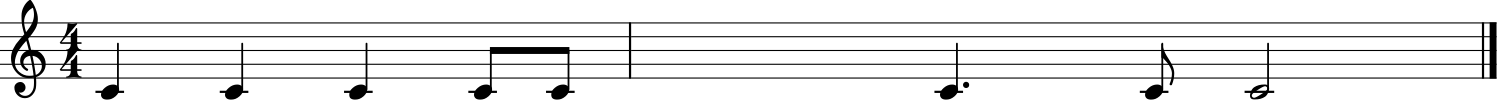

[[0.0], [0.0], [0.0], [0.0, 0.5], [0.0], [0.5], [0.0], []]


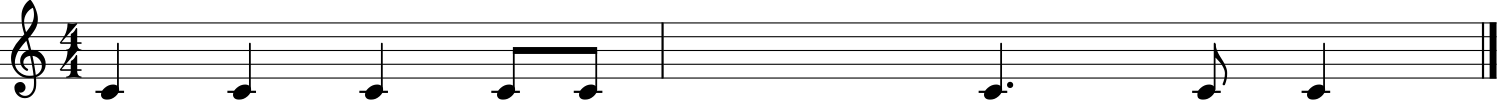

[1.0, 0.25, 0.5, 0.25, 0.125, 1.0, 0.125, 0.5]


In [23]:
test_score.show()
# test_score.show('text')
cons = construct_rhythm(rhythm_word(test_score))
cons.show()
# cons.show('text')
print(get_strengths(rhythm_word(test_score)))

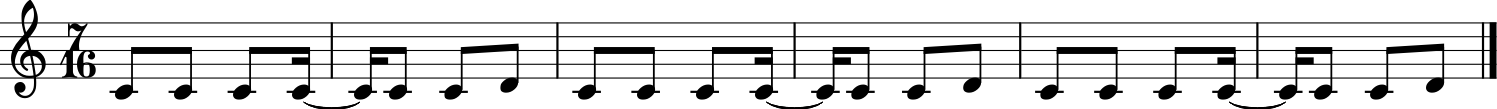

[[0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], [], [0.0], []]


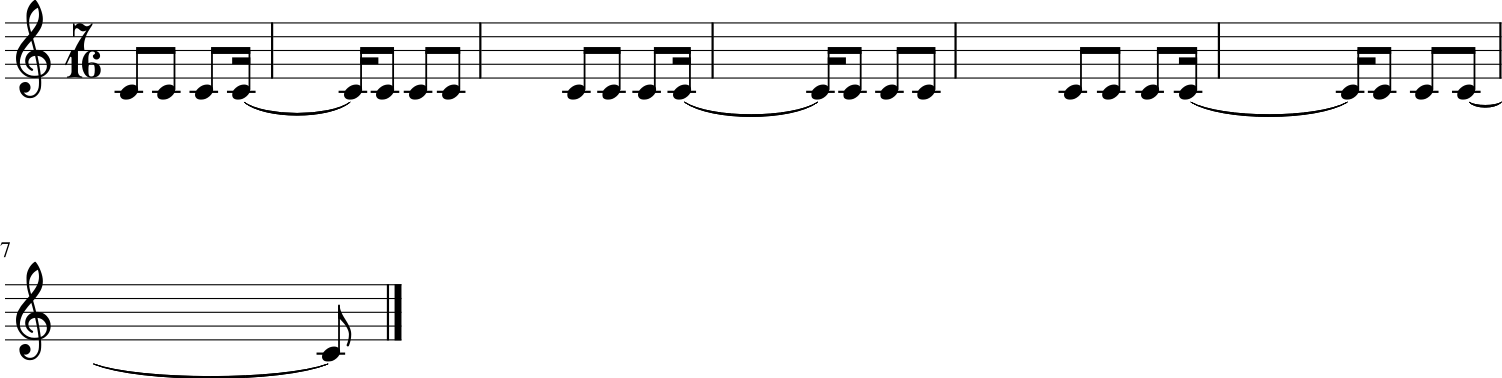

[1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


In [24]:
s4.show()
# test_score.show('text')
cons4 = construct_rhythm(rhythm_word(s4), ts=m21.meter.TimeSignature('7/16'))
cons4.show()
# cons.show('text')
print(get_strengths(rhythm_word(s4), ts=m21.meter.TimeSignature('7/16')))

In [68]:
ledZep = m21.converter.parseFile("/home/arran/projects/guitarPro/LedZep3.mxl")

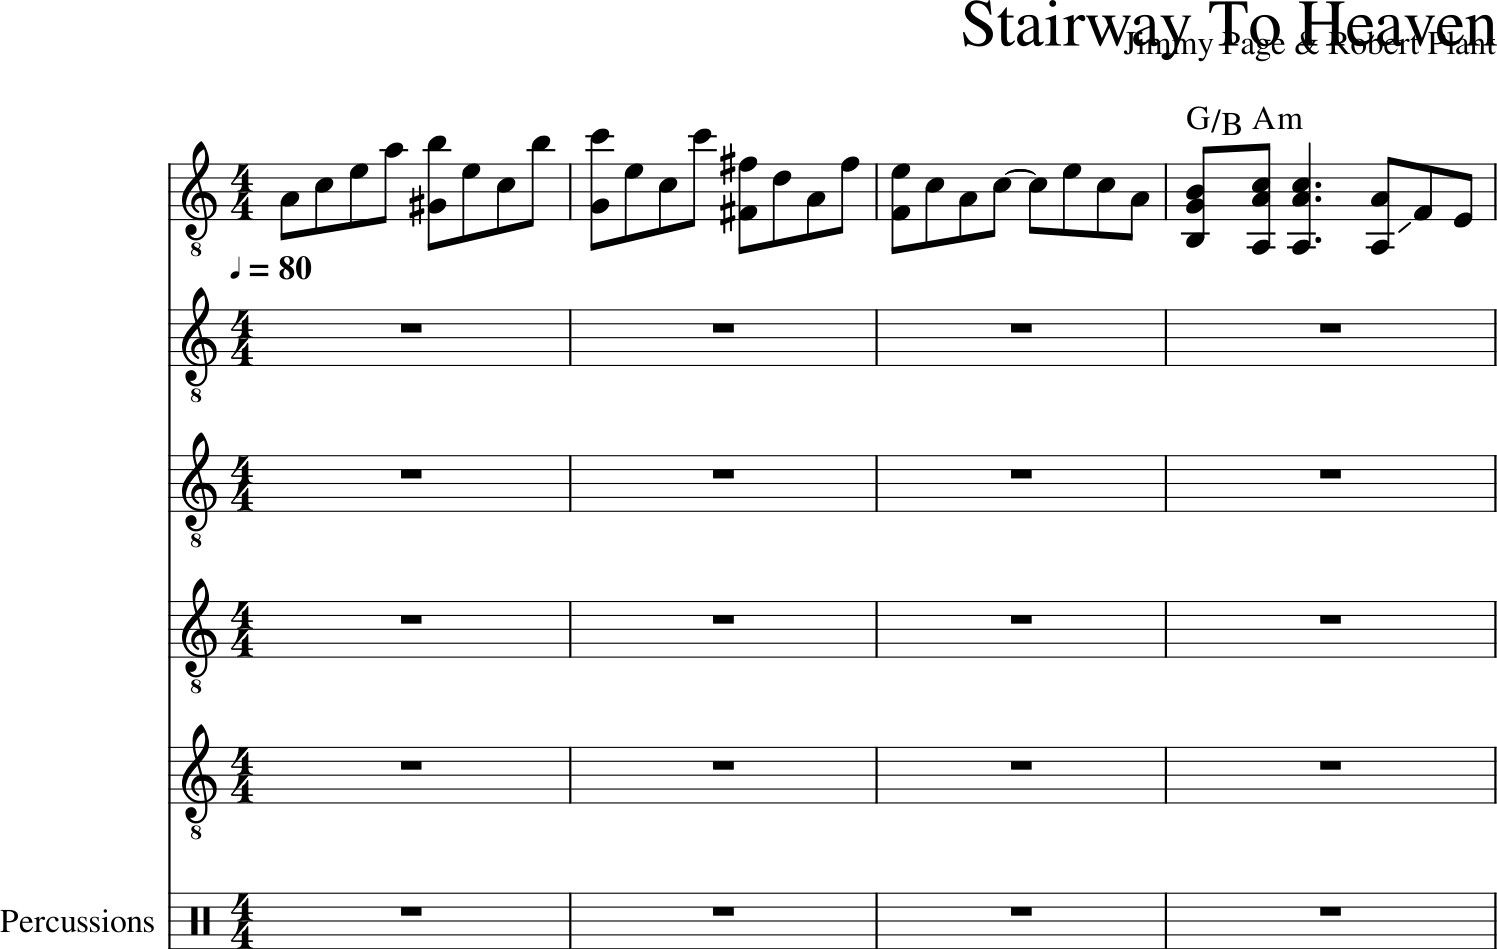

In [8]:
ledZep.show()

In [40]:
ledZep.show('midi')

In [69]:
cLedZep = clean_score(ledZep, verbose=True)

Cleaning...
Found Key (a minor)...
<music21.stream.Part 0x7f918ce5af98> ----------
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
<music21.stream.Part 0x7f918eb3a390> ----------
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found

rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
rest bar found
<music21.stream.Part Percussions> ----------
Percussion, skipping!


In [63]:
rhythm_word(cLedZep.parts[0], verbose=True)

New ts:  <music21.meter.TimeSignature 4/4> 1
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0]
[0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0]
[]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.25, 0.5]
[0.0]
[]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0]
[]
[0.0]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0]
[]
[0.0]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.5]
[0.0, 0.5]
[0.0, 0.5]
[0.0]
[]
[0.0, 0.5

[[0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0],
 [0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0],
 [],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.25, 0.5],
 [0.0],
 [],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0],
 [],
 [0.0],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0],
 [],
 [0.0],
 [0.0, 0.5],
 [0.0, 0.5],
 [0.0, 0.5],
 [

In [64]:
parse_note_data(cLedZep.parts[0])

[(1.0, 0.5, '0', 3),
 (0.125, 0.5, '3', 3),
 (0.25, 0.5, '7', 3),
 (0.125, 0.5, '0', 4),
 (0.5, 0.5, '11+', 2),
 (0.5, 0.5, '2', 4),
 (0.125, 0.5, '7', 3),
 (0.25, 0.5, '3', 3),
 (0.125, 0.5, '2', 4),
 (1.0, 0.5, '10+', 2),
 (1.0, 0.5, '3', 4),
 (0.125, 0.5, '7', 3),
 (0.25, 0.5, '3', 3),
 (0.125, 0.5, '3', 4),
 (0.5, 0.5, '9+', 2),
 (0.5, 0.5, '9', 3),
 (0.125, 0.5, '5', 3),
 (0.25, 0.5, '0', 3),
 (0.125, 0.5, '9', 3),
 (1.0, 0.5, '8+', 2),
 (1.0, 0.5, '7', 3),
 (0.125, 0.5, '3', 3),
 (0.25, 0.5, '0', 3),
 (0.125, 0.5, '3', 3),
 (0.125, 0.5, '7', 3),
 (0.25, 0.5, '3', 3),
 (0.125, 0.5, '0', 3),
 (1.0, 0.5, '2+', 2),
 (1.0, 0.5, '5+', 2),
 (1.0, 0.5, '10+', 2),
 (1.0, 0.5, '2', 3),
 (0.125, 0.5, '0+', 2),
 (0.125, 0.5, '3+', 2),
 (0.125, 0.5, '7+', 2),
 (0.125, 0.5, '0+', 3),
 (0.125, 0.5, '3', 3),
 (0.25, 1.5, '0+', 2),
 (0.25, 1.5, '0+', 3),
 (0.25, 1.5, '3', 3),
 (0.125, 0.5, '0+', 2),
 (0.125, 0.5, '0', 3),
 (0.25, 0.5, '8', 2),
 (0.125, 0.5, '7', 2),
 (1.0, 0.5, '0', 2),
 (0.125, 

In [111]:
ws = m21.converter.parse('/home/arran/projects/guitarPro/WS.mxl')

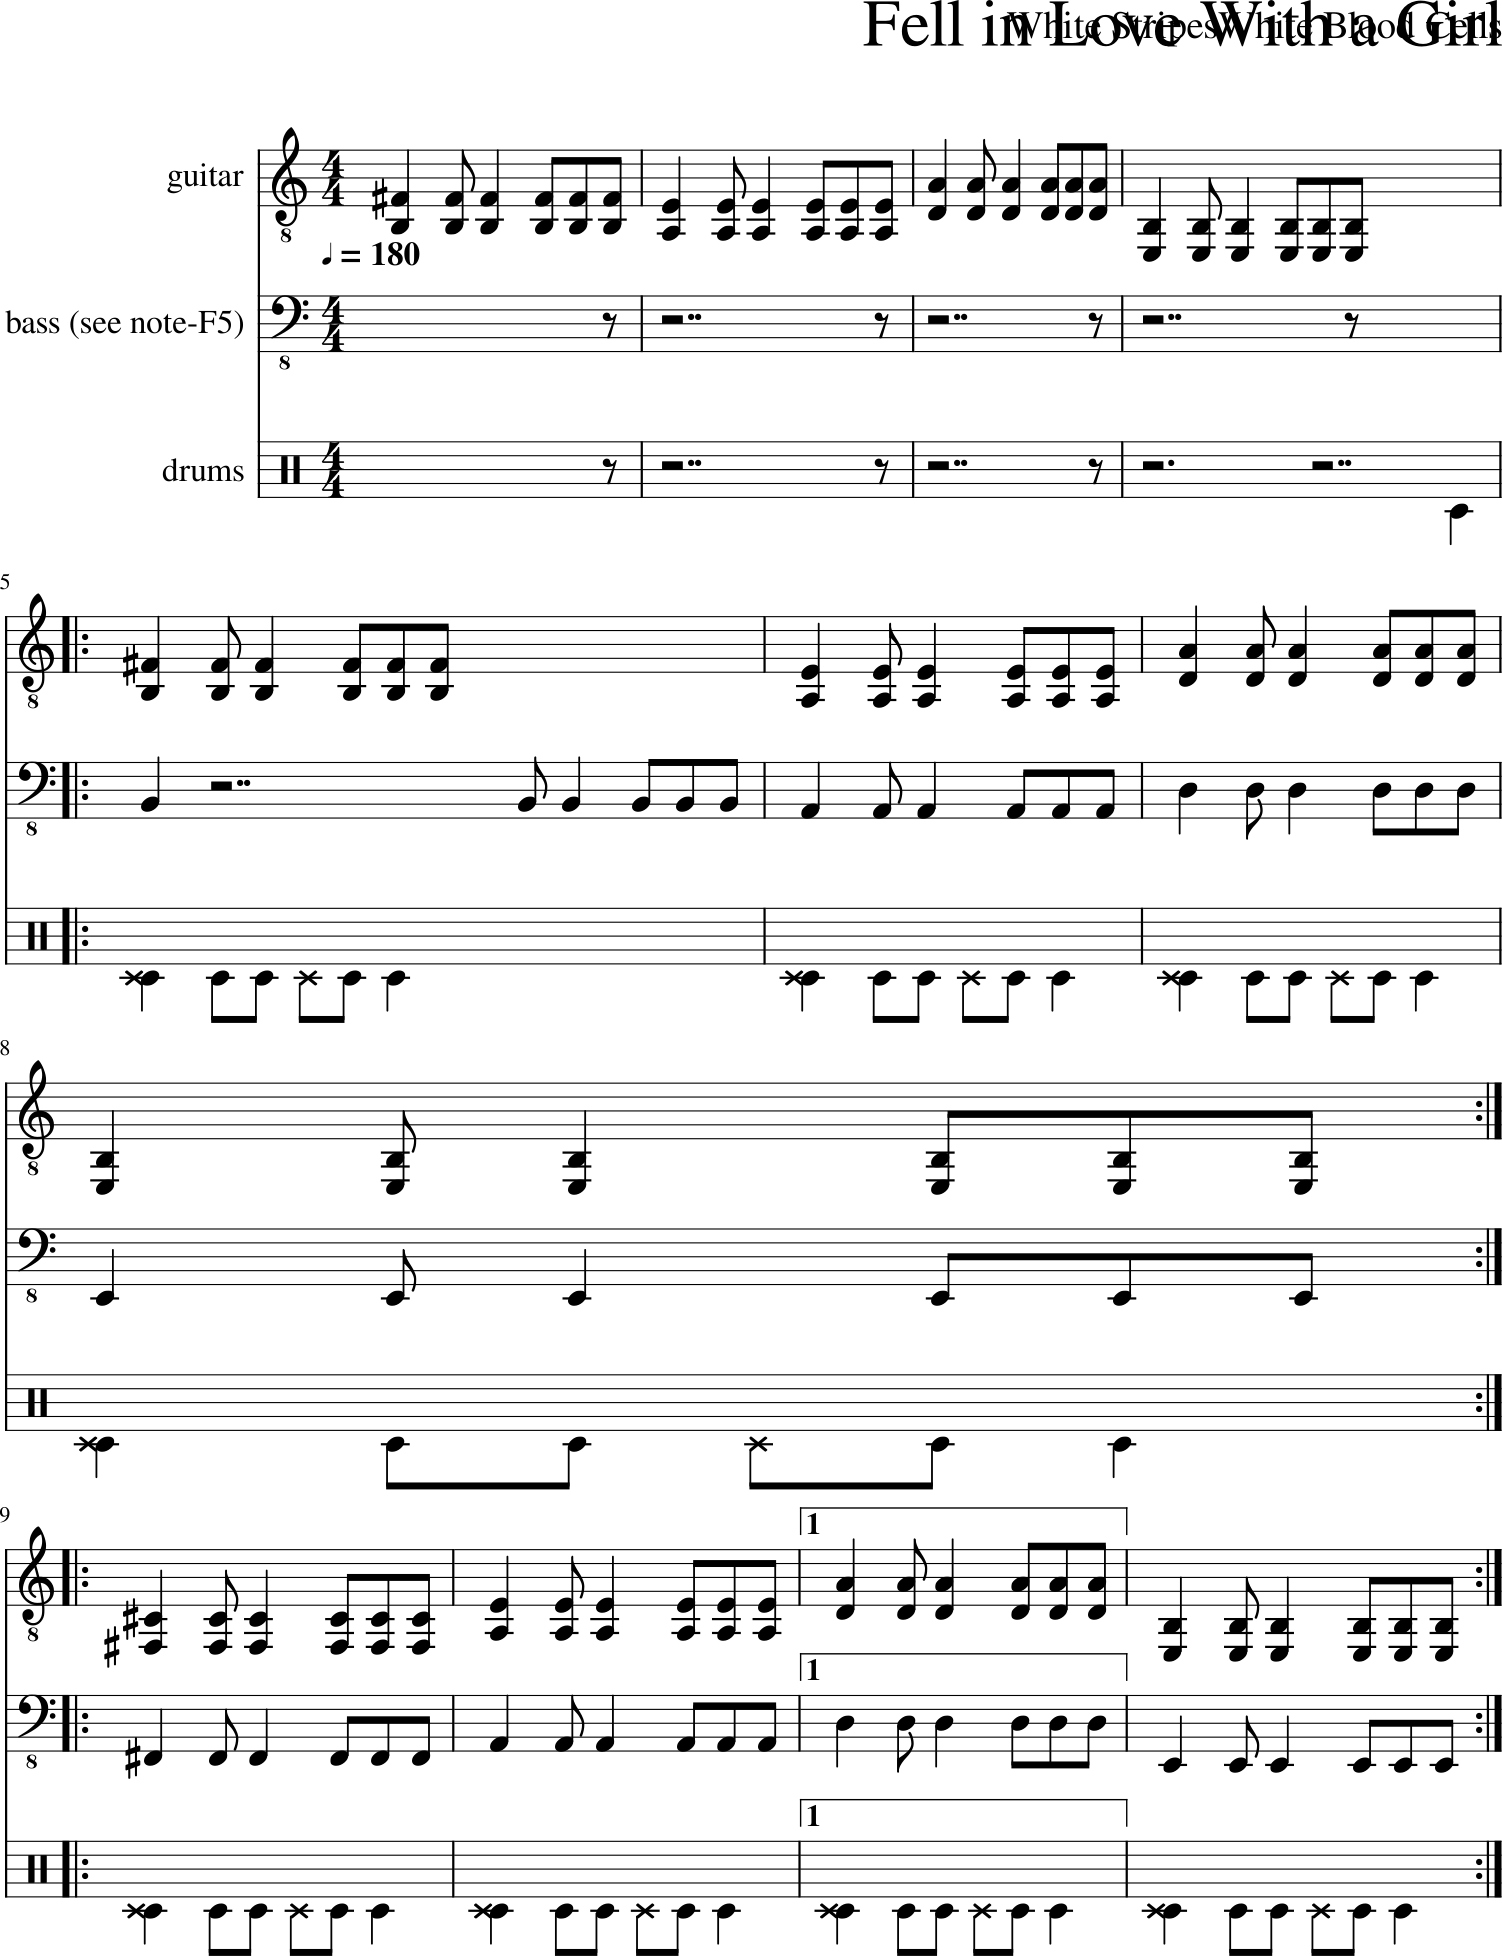

In [68]:
ws.show()

In [149]:
cWS = clean_score(ws)

In [127]:
parse_note_data(cWS.parts[0])

[(1.0, 1.0, '2+', 2),
 (1.0, 1.0, '9', 2),
 (0.25, 0.5, '2+', 2),
 (0.25, 0.5, '9', 2),
 (0.125, 1.0, '2+', 2),
 (0.125, 1.0, '9', 2),
 (0.125, 0.5, '2+', 2),
 (0.125, 0.5, '9', 2),
 (0.25, 0.5, '2+', 2),
 (0.25, 0.5, '9', 2),
 (0.125, 0.5, '2+', 2),
 (0.125, 0.5, '9', 2),
 (1.0, 1.0, '0+', 2),
 (1.0, 1.0, '7', 2),
 (0.25, 0.5, '0+', 2),
 (0.25, 0.5, '7', 2),
 (0.125, 1.0, '0+', 2),
 (0.125, 1.0, '7', 2),
 (0.125, 0.5, '0+', 2),
 (0.125, 0.5, '7', 2),
 (0.25, 0.5, '0+', 2),
 (0.25, 0.5, '7', 2),
 (0.125, 0.5, '0+', 2),
 (0.125, 0.5, '7', 2),
 (1.0, 1.0, '5+', 2),
 (1.0, 1.0, '0', 3),
 (0.25, 0.5, '5+', 2),
 (0.25, 0.5, '0', 3),
 (0.125, 1.0, '5+', 2),
 (0.125, 1.0, '0', 3),
 (0.125, 0.5, '5+', 2),
 (0.125, 0.5, '0', 3),
 (0.25, 0.5, '5+', 2),
 (0.25, 0.5, '0', 3),
 (0.125, 0.5, '5+', 2),
 (0.125, 0.5, '0', 3),
 (1.0, 1.0, '7+', 1),
 (1.0, 1.0, '2', 2),
 (0.25, 0.5, '7+', 1),
 (0.25, 0.5, '2', 2),
 (0.125, 1.0, '7+', 1),
 (0.125, 1.0, '2', 2),
 (0.125, 0.5, '7+', 1),
 (0.125, 0.5, '2', 

In [147]:
def metaAnalysis(stream):
    '''
    Args:
        - stream: to be analysed
    Returns:
        - analysis: dictionary of results, where
            - 'span' : pitch span
            - 'avgInt' : average interval size
            - 'avgChord' : proportion of chords
            - 'tonalCenter' : mean MIDI value
    '''
    
    def get_pitch(note):
        if isinstance(note, m21.chord.Chord):
            return note.root().midi
        else:
            return note.pitch.midi
    
    result = list()
    
    if isinstance(stream, m21.stream.Score):
        parts = stream.parts
    else:
        parts = [stream]
        
    mid = m21.analysis.discrete.MelodicIntervalDiversity()
        
    for part in parts:
        analysis = dict()

        notes = part.flat.notes
        
        midiPitches = list(map(get_pitch, notes))
        
        span = max(midiPitches) - min(midiPitches)
        
        tonalCenter = sum(midiPitches)/len(midiPitches)
        
        ints = [abs(i-j) for i, j in zip(midiPitches[:-1], midiPitches[1:])]
        avgInt = sum(ints)/len(ints)

        avgChord = len(part.flat.getElementsByClass(m21.chord.Chord))/len(notes)
        
        analysis = {'span': span, 
                    'avgInt': avgInt, 
                    'avgChord': avgChord,
                    'tonalCenter': tonalCenter}
        
        result.append(analysis)

    return result

In [148]:
metaAnalysis(clean_score(s1))

[{'span': 19,
  'avgInt': 3.0526315789473686,
  'avgChord': 0.0,
  'tonalCenter': 59.810457516339866},
 {'span': 12,
  'avgInt': 2.289855072463768,
  'avgChord': 0.0,
  'tonalCenter': 65.81428571428572},
 {'span': 14,
  'avgInt': 1.7272727272727273,
  'avgChord': 0.0,
  'tonalCenter': 60.61797752808989},
 {'span': 14,
  'avgInt': 1.934782608695652,
  'avgChord': 0.0,
  'tonalCenter': 54.30107526881721},
 {'span': 21,
  'avgInt': 3.3260869565217392,
  'avgChord': 0.0,
  'tonalCenter': 47.32258064516129}]

In [150]:
metaAnalysis(cWS)

[{'span': 10,
  'avgInt': 0.8808664259927798,
  'avgChord': 1.0,
  'tonalCenter': 35.884892086330936},
 {'span': 10,
  'avgInt': 0.8695652173913043,
  'avgChord': 0.0,
  'tonalCenter': 23.826771653543307}]

In [72]:
metaAnalysis(cLedZep.parts[1])

(38, 0.0, 0.5128205128205128)

In [ ]:
mid = m21.analysis.discrete.MelodicIntervalDiversity()
ints = mid.countMelodicIntervals(cLedZep.parts[0], ignoreUnison=False, ignoreDirection=True)


In [8]:
def get_roles(stream, corpus='music21', metaAnalysis=None):
    '''
    Given a stream, return a list of which model (instrument/voice/role) it should be.
    Args:
        Corpus - 'music21', 'guitarPro', 'piano'
        MetaAnalysis - optional list of metaAnalysis data for each part to aid instrument classification
    
    Returns - list of model numbers 
    '''
    
    models = {'Omni':          0,
              'Voice Soprano': 1,
              'Voice Alto':    2,
              'Voice Tenor':   3,
              'Voice Bass':    4,
              'Lead 1':        5,
              'Lead 2':        6,
              'Piano Left':    7,
              'Piano Right':   8,
              'Guitar Lead':   9,
              'Guitar Rhythm': 10,
              'Guitar Bass':   11
             }
    
    
    # get all the parts, if multiple exist in score
    if isinstance(stream, m21.stream.Score):
        parts = stream.parts
    else:
        parts = [stream]
    
    # final result
    result = list()
    
    # keep track of how many lead parts in stream
    lead = 1
    
    for i, part in enumerate(parts):
        insName = part.flat.getInstrument().bestName().lower()
        if not insName:
            if metaAnalysis:
                # try to guess from analysis
                ma = metaAnalysis[i]
                if ma[2] == 0:
                    # could be voice or lead
                    
                else:
                    # could be piano, guitar or lead
                    
            else:
                # no metaAnalysis
                
                
            result.append(models['Omni'])
            continue
        
        if corpus == 'music21' or corpus == 'piano':
            if 'soprano' in insName:
                result.append(models['Voice Soprano'])
            elif 'alto' in insName:
                result.append(models['Voice Alto'])
            elif 'tenor' in insName:
                result.append(models['Voice Tenor'])
            elif 'bass' in insName:
                result.append(models['Voice Bass'])
            elif 'piano' in insName:
                clef = part.flat.clef
                if isInstance(clef, m21.clef.TrebleClef):
                    result.append(models['Piano Right'])
                else:
                    result.append(models['Piano Left'])
            elif 'guitar' in insName:
                if lead == 1:
                    result.append(models['Guitar Lead'])
                    lead += 1
                else:
                    result.append(models['Guitar Rhythm'])
            else:
                # assume lead
                result.append(models[f'Lead {min(lead, 2)}'])
                lead += 1
        
        elif corpus == 'guitarPro':
            if 'bass' in insName:
                result.append(models['Guitar Bass'])
            elif 'guitar' in insName:
                if lead == 1:
                    result.append(models['Guitar Lead'])
                    lead += 1
                else:
                    result.append(models['Guitar Rhythm'])
            else:
                # do further tests to determin instrument
                a = m21.analysis.discrete.Ambitus()
                if a.getPitchSpan(cWS.parts[1])[0].octave <= 0:
                    # lowest note is bass
                    result.append(models['Guitar Bass'])
                    continue
                    
                if metaAnalysis:
                    ma = metaAnalysis[i]
                    if ma[2] < 0.25:
                        # not many chords, assume lead guitar
                        result.append(models['Guitar Bass'])
                    else:
                        result.append(models['Guitar Rhythm'])
                else:
                    
            
            
        else:
            print(f'UNKOWN CORPUS: {corpus}, assuming Omni...')
            result.append(models['Omni'])
            break
        
    
    
    
    
    
    
    

In [10]:
path = m21.corpus.getComposer('chopin')

In [17]:
chopin = m21.corpus.parse(path[0])
cChopin = clean_score(chopin)

In [93]:
a = m21.analysis.discrete.Ambitus()
a.getPitchSpan(cLedZep.parts[3])[1].octave


5

In [128]:
midiPitches = list(map(get_pitch, cWS.parts[0].flat.notes))

In [143]:
len(clean_score(s1).parts[1].flat.getElementsByClass(m21.chord.Chord))

1

In [146]:
clean_score(s1).show('text')

{0.0} <music21.stream.Part 0x7f91871f7ba8>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.instrument.Instrument P1: Horn 2: Instrument 7>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.key.Key of C major>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.note.Rest rest>
        {3.0} <music21.note.Note C>
    {4.0} <music21.stream.Measure 2 offset=4.0>
        {0.0} <music21.note.Note D>
        {0.5} <music21.note.Note G>
        {1.0} <music21.note.Note C>
        {1.5} <music21.note.Note C>
        {2.0} <music21.note.Note E>
        {2.5} <music21.note.Note C>
        {3.0} <music21.note.Note E>
        {3.5} <music21.note.Note G>
    {8.0} <music21.stream.Measure 3 offset=8.0>
        {0.0} <music21.note.Note C>
        {0.25} <music21.note.Note F>
        {0.5} <music21.note.Note E>
        {0.75} <music21.note.Note D>
        {1.0} <music21.note.Note C>
        {1.5} <music21.note.Note D>
        {2.0} <music21.note.No